## Import Data

In [101]:
!ls .././data | sort

busstops_norway.csv
grunnkrets_age_distribution.csv
grunnkrets_households_num_persons.csv
grunnkrets_income_households.csv
grunnkrets_norway_stripped.csv
plaace_hierarchy.csv
sample_submission.csv
stores_extra.csv
stores_test.csv
stores_train.csv


## Libraries

In [102]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing

## Settings

In [103]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
plt.figure(figsize=(9, 7))
plt.style.use('bmh')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 50}

plt.rc('font', **font)

<Figure size 648x504 with 0 Axes>

## Import Files

In [104]:
stores_train = pd.read_csv('../data/stores_train.csv')
stores_test = pd.read_csv('../data/stores_test.csv')
stores_extra = pd.read_csv('../data/stores_extra.csv')
plaace_hierarchy = pd.read_csv('../data/plaace_hierarchy.csv')
grunnkrets = pd.read_csv('../data/grunnkrets_norway_stripped.csv')
grunnkrets_ages = pd.read_csv('../data/grunnkrets_age_distribution.csv')
grunnkrets_household_types = pd.read_csv('../data/grunnkrets_households_num_persons.csv')
grunnkrets_household_income = pd.read_csv('../data/grunnkrets_income_households.csv')
busstops = pd.read_csv('../data/busstops_norway.csv')

## RMSLE Function

In [105]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

# Merging all the Datasets

## Merging plaace_hierarchy with Stores data

In [106]:
# Augment stores_train with information about the hierarchy
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
stores_with_hierarchy_test = stores_test.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

# Show dataframe, but transposed so that we can more easily see all the resulting columns
stores_with_hierarchy.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants


In [107]:
# Convert latitude, longitude to polar coordinates
def cartesian_to_polar_coordinates(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)
    
geographical_weighted_center_latitude = np.average(stores_with_hierarchy["lat"])
geographical_weighted_center_longitude = np.average(stores_with_hierarchy["lon"])

delta_latitude = stores_with_hierarchy["lat"] - geographical_weighted_center_latitude
delta_longitude = stores_with_hierarchy["lon"] - geographical_weighted_center_longitude

stores_with_hierarchy["distance_from_center"], stores_with_hierarchy["angle"] = cartesian_to_polar_coordinates(delta_latitude, delta_longitude)


geographical_weighted_center_latitude = np.average(stores_with_hierarchy_test["lat"])
geographical_weighted_center_longitude = np.average(stores_with_hierarchy_test["lon"])

delta_latitude = stores_with_hierarchy_test["lat"] - geographical_weighted_center_latitude
delta_longitude = stores_with_hierarchy_test["lon"] - geographical_weighted_center_longitude

stores_with_hierarchy_test["distance_from_center"], stores_with_hierarchy_test["angle"] = cartesian_to_polar_coordinates(delta_latitude, delta_longitude)

## Merging Grunnkrets with Stores data

In [108]:
grunnkrets_2016 = grunnkrets.loc[grunnkrets['year'] == 2016]
stores_with_hierarchy_grunnkrets = pd.merge(stores_with_hierarchy, grunnkrets_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_test = pd.merge(stores_with_hierarchy_test, grunnkrets_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_test


,store_id,year_x,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,mall_name,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc,distance_from_center,angle,year_y,grunnkrets_name,district_name,municipality_name,geometry,area_km2
0,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,NaN,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.530048,2.634062,2016.0,Vålerenga rode 4,Vålerenga,Oslo,"POLYGON((10.7867135984557 59.908762574244, 10....",0.057027
1,916789157-916823770-824309,2016,BURGER KING MYREN,1.1.1.0,Hamburger restaurants,8061401,MYREN 1,59.201467,9.588243,BURGER KING,NaN,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2.094441,-2.922530,2016.0,Kjempa,Gulset,Skien,MULTIPOLYGON(((9.57990302232997 59.20175739826...,0.165993
2,913341082-977479363-2948,2016,BURGER KING STOVNER,1.1.1.0,Hamburger restaurants,3013917,STOVNER SENTER 3,59.962146,10.924524,BURGER KING,Stovner Senter,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.557014,2.540058,2016.0,Stovner senter,Fossum,Oslo,"POLYGON((10.9327714172545 59.9614144471754, 10...",0.236628
3,889682582-889697172-28720,2016,BURGER KING TUNGASLETTA,1.1.1.0,Hamburger restaurants,16012104,TUNGASLETTA 16,63.420785,10.461091,BURGER KING,NaN,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2.214677,0.189739,2016.0,Strindheim 4,Strindheim,Trondheim,"POLYGON((10.459001199372 63.424320840557, 10.4...",0.983436
4,997991699-998006945-417222,2016,VULKAN BURGERBAR,1.1.1.0,Hamburger restaurants,3014305,AUD SCHØNEMANNS VEI 15,59.921102,10.785123,VULKAN BURGERBAR,NaN,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.518264,2.631182,2016.0,Lille Tøyen,Hasle,Oslo,"POLYGON((10.7815720596407 59.9175770831722, 10...",0.449502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8572,917323003-917383529-844309,2016,GULATING HAUGESUND,2.8.11.2,Beer and soda shop,11490601,BRÅTAVEGEN 30,59.259575,5.325813,GULATING GRUPPEN,NaN,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,5.118681,-1.969306,2016.0,Stokkastrand,Kopervik,Karmøy,MULTIPOLYGON(((5.32136787489711 59.23099432230...,1.708924
8573,917353379-917411824-845904,2016,STAVANGER BEER AS,2.8.11.2,Beer and soda shop,11030901,SANDVIGÅ 7,58.976219,5.721546,NaN,NaN,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,4.881560,-2.054364,2016.0,Bjergsted,Kampen,Stavanger,"POLYGON((5.72714116927016 58.9724047824004, 5....",0.310575
8574,917072302-917089248-833647,2016,GULATING ØLUTSALG OG PUB,2.8.11.2,Beer and soda shop,2270103,GARDERBAKKEN 6,59.928330,11.163202,GULATING GRUPPEN,NaN,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,1.729114,2.437138,2016.0,Fetsund,Hovinhøgda,Fet,"POLYGON((11.1631232250592 59.9379356074191, 11...",1.627789
8575,916960557-916993161-829908,2016,VI BRYGGER BUTIKKDRIFT AS,2.8.11.2,Beer and soda shop,12470701,RAVNANGERVEGEN,60.445790,5.161587,NaN,NaN,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,4.946935,-1.733239,2016.0,Haugland,Haugland/Davanger/Ramsøy,Askøy,MULTIPOLYGON(((5.18520140772538 60.44242290291...,1.103012


In [109]:
grunnkrets_ages
grunnkrets_ages_2016 = grunnkrets_ages.loc[grunnkrets_ages['year'] == 2016]
stores_with_hierarchy_grunnkrets_age = pd.merge(stores_with_hierarchy_grunnkrets, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_test = pd.merge(stores_with_hierarchy_grunnkrets_test, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age

# Feature engineering: Age binning
under_18 = grunnkrets_ages.loc[: , "age_0":"age_18"]
above_18 = grunnkrets_ages.loc[: , "age_19":"age_90"]
grunnkrets_ages['0_to_18'] = under_18.sum(axis = 1)
grunnkrets_ages['19_to_90'] = above_18.sum(axis = 1)
grunnkrets_ages = grunnkrets_ages.drop(grunnkrets_ages.iloc[:, 2:93],axis = 1) # drop age columns

grunnkrets_ages_2016 = grunnkrets_ages.loc[grunnkrets_ages['year'] == 2016]
stores_with_hierarchy_grunnkrets_age = pd.merge(stores_with_hierarchy_grunnkrets, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_test = pd.merge(stores_with_hierarchy_grunnkrets_test, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age['0_to_18'] = stores_with_hierarchy_grunnkrets_age['0_to_18'].fillna((stores_with_hierarchy_grunnkrets_age['0_to_18'].mean()))
stores_with_hierarchy_grunnkrets_age['19_to_90'] = stores_with_hierarchy_grunnkrets_age['19_to_90'].fillna((stores_with_hierarchy_grunnkrets_age['19_to_90'].mean()))

stores_with_hierarchy_grunnkrets_age

,store_id,year_x,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc,distance_from_center,angle,year_y,grunnkrets_name,district_name,municipality_name,geometry,area_km2,year,0_to_18,19_to_90
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.483925,2.999938,2016.0,Bragernes sentrum 3,Bragernes sentrum,Drammen,"POLYGON((10.2046156903846 59.7447808519649, 10...",0.155779,2016.0,25.000000,132.000000
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.493786,2.624389,2016.0,Sentrum 3 /rode 6,Sentrum 3,Oslo,"POLYGON((10.7303654475615 59.9107195782207, 10...",0.264278,NaN,143.178518,622.172205
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.079018,2.898973,2016.0,Sydsiden 2,Hønefoss,Ringerike,"POLYGON((10.2654039198422 60.1639238060368, 10...",0.160152,2016.0,67.000000,305.000000
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,7.489049,0.625420,2016.0,Sentrum 1,Sentrum,Bodø,"POLYGON((14.3800126797167 67.2852351710009, 14...",0.095029,2016.0,46.000000,428.000000
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2.179184,0.174997,2016.0,Tiller-Hårstad 14,Tiller-Hårstad,Trondheim,"POLYGON((10.3709720705149 63.3579302939404, 10...",0.251070,NaN,143.178518,622.172205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,915789943-915806929-781991,2016,MEIERIGÅRDEN BRYGGERIUTSALG,2.8.11.2,Beer and soda shop,7010705,THUEGATA 2,59.416276,10.480970,NaN,NaN,0.088,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,1.860369,2.877541,2016.0,Sentrum,Sentrum,Horten,"POLYGON((10.4844343691104 59.4185964815712, 10...",0.291337,2016.0,194.000000,1322.000000
12855,917921733-917982368-868081,2016,GULATING ØLUTSALG CC GJØVIK,2.8.11.2,Beer and soda shop,5020406,NaN,60.799991,10.693635,GULATING GRUPPEN,CC Gjøvik,1.816,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,0.810793,2.104077,2016.0,Sentrum 6,Sentrum,Gjøvik,"POLYGON((10.6971768573538 60.7988198867219, 10...",0.137188,2016.0,42.000000,461.000000
12856,911721961-911764474-496764,2016,GULATING ØLUTSALG STRØMMEN,2.8.11.2,Beer and soda shop,2310803,STØPERIVEIEN 6,59.946562,11.007659,GULATING GRUPPEN,Strømmen Storsenter,38.225,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,1.620608,2.466972,2016.0,Stalsberg 3,Stalsberg,Skedsmo,"POLYGON((11.0040997448376 59.9483583629928, 11...",0.123431,2016.0,145.000000,972.000000
12857,914337046-914343372-721294,2016,DET GODE BRYGG,2.8.11.2,Beer and soda shop,11020113,VÅGSGATA 16,58.850261,5.735674,NaN,Bystasjonen,3.642,Beer and soda shop,2,Retail,2.8,Food and drinks,2.

In [110]:
grunnkrets_household_types
grunnkrets_household_types_2016 = grunnkrets_household_types.loc[grunnkrets_household_types['year'] == 2016]
stores_with_hierarchy_grunnkrets_age_hhtypes = pd.merge(stores_with_hierarchy_grunnkrets_age, grunnkrets_household_types_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_hhtypes_test = pd.merge(stores_with_hierarchy_grunnkrets_age_test, grunnkrets_household_types_2016, how='left', on='grunnkrets_id')

stores_with_hierarchy_grunnkrets_age_hhtypes


,store_id,year_x,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc,distance_from_center,angle,year_y,grunnkrets_name,district_name,municipality_name,geometry,area_km2,year_x,0_to_18,19_to_90,year_y,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.483925,2.999938,2016.0,Bragernes sentrum 3,Bragernes sentrum,Drammen,"POLYGON((10.2046156903846 59.7447808519649, 10...",0.155779,2016.0,25.000000,132.000000,2016.0,20.0,0.0,8.0,28.0,4.0,6.0,11.0,75.0
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.493786,2.624389,2016.0,Sentrum 3 /rode 6,Sentrum 3,Oslo,"POLYGON((10.7303654475615 59.9107195782207, 10...",0.264278,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.079018,2.898973,2016.0,Sydsiden 2,Hønefoss,Ringerike,"POLYGON((10.2654039198422 60.1639238060368, 10...",0.160152,2016.0,67.000000,305.000000,2016.0,45.0,9.0,38.0,84.0,13.0,6.0,12.0,150.0
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,7.489049,0.625420,2016.0,Sentrum 1,Sentrum,Bodø,"POLYGON((14.3800126797167 67.2852351710009, 14...",0.095029,2016.0,46.000000,428.000000,2016.0,41.0,10.0,27.0,126.0,11.0,8.0,15.0,254.0
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2.179184,0.174997,2016.0,Tiller-Hårstad 14,Tiller-Hårstad,Trondheim,"POLYGON((10.3709720705149 63.3579302939404, 10...",0.251070,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,915789943-915806929-781991,2016,MEIERIGÅRDEN BRYGGERIUTSALG,2.8.11.2,Beer and soda shop,7010705,THUEGATA 2,59.416276,10.480970,NaN,NaN,0.088,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,1.860369,2.877541,2016.0,Sentrum,Sentrum,Horten,"POLYGON((10.4844343691104 59.4185964815712, 10...",0.291337,2016.0,194.000000,1322.000000,2016.0,159.0,53.0,113.0,488.0,46.0,36.0,58.0,556.0
12855,917921733-917982368-868081,2016,GULATING ØLUTSALG CC GJØVIK,2.8.11.2,Beer and soda shop,5020406,NaN,60.799991,10.693635,GULATING GRUPPEN,CC Gjøvik,1.816,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,0.810793,2.104077,2016.0,Sentrum 6,Sentrum,Gjøvik,"POLYGON((10.6971768573538 60.7988198867219, 10...",0.137188,2016.0,42.000000,461.000000,2016.0,47.0,9.0,14.0,138.0,5.0,7.0,19.0,256.0
12856,911721961-911764474-49676

In [111]:
grunnkrets_household_income
grunnkrets_household_income_2016 = grunnkrets_household_income.loc[grunnkrets_household_income['year'] == 2016]
stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome = pd.merge(stores_with_hierarchy_grunnkrets_age_hhtypes, grunnkrets_household_income_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome_test = pd.merge(stores_with_hierarchy_grunnkrets_age_hhtypes_test, grunnkrets_household_income_2016, how='left', on='grunnkrets_id')

stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome


,store_id,year_x,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc,distance_from_center,angle,year_y,grunnkrets_name,district_name,municipality_name,geometry,area_km2,year_x,0_to_18,19_to_90,year_y,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children_x,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles_x,year,all_households,singles_y,couple_without_children_y,couple_with_children,other_households,single_parent_with_children
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.483925,2.999938,2016.0,Bragernes sentrum 3,Bragernes sentrum,Drammen,"POLYGON((10.2046156903846 59.7447808519649, 10...",0.155779,2016.0,25.000000,132.000000,2016.0,20.0,0.0,8.0,28.0,4.0,6.0,11.0,75.0,2016.0,398700.0,277500.0,669100.0,832800.0,679600.0,349500.0
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.493786,2.624389,2016.0,Sentrum 3 /rode 6,Sentrum 3,Oslo,"POLYGON((10.7303654475615 59.9107195782207, 10...",0.264278,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2016.0,374800.0,295000.0,679600.0,802200.0,604100.0,397700.0
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.079018,2.898973,2016.0,Sydsiden 2,Hønefoss,Ringerike,"POLYGON((10.2654039198422 60.1639238060368, 10...",0.160152,2016.0,67.000000,305.000000,2016.0,45.0,9.0,38.0,84.0,13.0,6.0,12.0,150.0,2016.0,347900.0,251900.0,589900.0,673100.0,637600.0,327000.0
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,7.489049,0.625420,2016.0,Sentrum 1,Sentrum,Bodø,"POLYGON((14.3800126797167 67.2852351710009, 14...",0.095029,2016.0,46.000000,428.000000,2016.0,41.0,10.0,27.0,126.0,11.0,8.0,15.0,254.0,2016.0,394000.0,293600.0,602000.0,675800.0,699600.0,335200.0
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2.179184,0.174997,2016.0,Tiller-Hårstad 14,Tiller-Hårstad,Trondheim,"POLYGON((10.3709720705149 63.3579302939404, 10...",0.251070,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2016.0,623700.0,296500.0,635700.0,779700.0,801300.0,413600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,915789943-915806929-781991,2016,MEIERIGÅRDEN BRYGGERIUTSALG,2.8.11.2,Beer and soda shop,7010705,THUEGATA 2,59.416276,10.480970,NaN,NaN,0.088,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,1.860369,2.877541,2016.0,Sentrum,Sentrum,Horten,"POLYGON((10.4844343691104 59.4185964815712, 10...",0.291337,2016.0,194.000000,1322.000000,2016.0,159.0,53.0,113.0,488.0,46.0,36.0,58.0,556.0,2016.0,381900

In [112]:
stores_train_merged = stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome
stores_test_merged = stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome_test
stores_train_merged

,store_id,year_x,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc,distance_from_center,angle,year_y,grunnkrets_name,district_name,municipality_name,geometry,area_km2,year_x,0_to_18,19_to_90,year_y,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children_x,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles_x,year,all_households,singles_y,couple_without_children_y,couple_with_children,other_households,single_parent_with_children
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.483925,2.999938,2016.0,Bragernes sentrum 3,Bragernes sentrum,Drammen,"POLYGON((10.2046156903846 59.7447808519649, 10...",0.155779,2016.0,25.000000,132.000000,2016.0,20.0,0.0,8.0,28.0,4.0,6.0,11.0,75.0,2016.0,398700.0,277500.0,669100.0,832800.0,679600.0,349500.0
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.493786,2.624389,2016.0,Sentrum 3 /rode 6,Sentrum 3,Oslo,"POLYGON((10.7303654475615 59.9107195782207, 10...",0.264278,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2016.0,374800.0,295000.0,679600.0,802200.0,604100.0,397700.0
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.079018,2.898973,2016.0,Sydsiden 2,Hønefoss,Ringerike,"POLYGON((10.2654039198422 60.1639238060368, 10...",0.160152,2016.0,67.000000,305.000000,2016.0,45.0,9.0,38.0,84.0,13.0,6.0,12.0,150.0,2016.0,347900.0,251900.0,589900.0,673100.0,637600.0,327000.0
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,7.489049,0.625420,2016.0,Sentrum 1,Sentrum,Bodø,"POLYGON((14.3800126797167 67.2852351710009, 14...",0.095029,2016.0,46.000000,428.000000,2016.0,41.0,10.0,27.0,126.0,11.0,8.0,15.0,254.0,2016.0,394000.0,293600.0,602000.0,675800.0,699600.0,335200.0
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2.179184,0.174997,2016.0,Tiller-Hårstad 14,Tiller-Hårstad,Trondheim,"POLYGON((10.3709720705149 63.3579302939404, 10...",0.251070,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2016.0,623700.0,296500.0,635700.0,779700.0,801300.0,413600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,915789943-915806929-781991,2016,MEIERIGÅRDEN BRYGGERIUTSALG,2.8.11.2,Beer and soda shop,7010705,THUEGATA 2,59.416276,10.480970,NaN,NaN,0.088,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,1.860369,2.877541,2016.0,Sentrum,Sentrum,Horten,"POLYGON((10.4844343691104 59.4185964815712, 10...",0.291337,2016.0,194.000000,1322.000000,2016.0,159.0,53.0,113.0,488.0,46.0,36.0,58.0,556.0,2016.0,381900

# Exploratory Data Analysis

In [113]:
df = stores_train_merged
df

,store_id,year_x,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc,distance_from_center,angle,year_y,grunnkrets_name,district_name,municipality_name,geometry,area_km2,year_x,0_to_18,19_to_90,year_y,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children_x,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles_x,year,all_households,singles_y,couple_without_children_y,couple_with_children,other_households,single_parent_with_children
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.483925,2.999938,2016.0,Bragernes sentrum 3,Bragernes sentrum,Drammen,"POLYGON((10.2046156903846 59.7447808519649, 10...",0.155779,2016.0,25.000000,132.000000,2016.0,20.0,0.0,8.0,28.0,4.0,6.0,11.0,75.0,2016.0,398700.0,277500.0,669100.0,832800.0,679600.0,349500.0
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.493786,2.624389,2016.0,Sentrum 3 /rode 6,Sentrum 3,Oslo,"POLYGON((10.7303654475615 59.9107195782207, 10...",0.264278,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2016.0,374800.0,295000.0,679600.0,802200.0,604100.0,397700.0
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.079018,2.898973,2016.0,Sydsiden 2,Hønefoss,Ringerike,"POLYGON((10.2654039198422 60.1639238060368, 10...",0.160152,2016.0,67.000000,305.000000,2016.0,45.0,9.0,38.0,84.0,13.0,6.0,12.0,150.0,2016.0,347900.0,251900.0,589900.0,673100.0,637600.0,327000.0
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,7.489049,0.625420,2016.0,Sentrum 1,Sentrum,Bodø,"POLYGON((14.3800126797167 67.2852351710009, 14...",0.095029,2016.0,46.000000,428.000000,2016.0,41.0,10.0,27.0,126.0,11.0,8.0,15.0,254.0,2016.0,394000.0,293600.0,602000.0,675800.0,699600.0,335200.0
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2.179184,0.174997,2016.0,Tiller-Hårstad 14,Tiller-Hårstad,Trondheim,"POLYGON((10.3709720705149 63.3579302939404, 10...",0.251070,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2016.0,623700.0,296500.0,635700.0,779700.0,801300.0,413600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,915789943-915806929-781991,2016,MEIERIGÅRDEN BRYGGERIUTSALG,2.8.11.2,Beer and soda shop,7010705,THUEGATA 2,59.416276,10.480970,NaN,NaN,0.088,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,1.860369,2.877541,2016.0,Sentrum,Sentrum,Horten,"POLYGON((10.4844343691104 59.4185964815712, 10...",0.291337,2016.0,194.000000,1322.000000,2016.0,159.0,53.0,113.0,488.0,46.0,36.0,58.0,556.0,2016.0,381900

In [114]:
# Ignore first
# s = df.pop('revenue') 
# new_df = pd.concat([df, s], 1)
# new_df
new_df = df

### Seperate the data set into numerical and categorical data

In [115]:
df_numerical_features = new_df.select_dtypes(exclude='object')
df_categorical_features = new_df.select_dtypes(include='object')
df_numerical_features

,year_x,grunnkrets_id,lat,lon,revenue,lv1,lv2,distance_from_center,angle,year_y,area_km2,year_x,0_to_18,19_to_90,year_y,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children_x,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles_x,year,all_households,singles_y,couple_without_children_y,couple_with_children,other_households,single_parent_with_children
0,2016,6020303,59.743104,10.204928,17.998,1,1.1,1.483925,2.999938,2016.0,0.155779,2016.0,25.000000,132.000000,2016.0,20.0,0.0,8.0,28.0,4.0,6.0,11.0,75.0,2016.0,398700.0,277500.0,669100.0,832800.0,679600.0,349500.0
1,2016,3010306,59.913759,10.734031,23.828,1,1.1,1.493786,2.624389,2016.0,0.264278,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2016.0,374800.0,295000.0,679600.0,802200.0,604100.0,397700.0
2,2016,6050102,60.164751,10.254656,16.099,1,1.1,1.079018,2.898973,2016.0,0.160152,2016.0,67.000000,305.000000,2016.0,45.0,9.0,38.0,84.0,13.0,6.0,12.0,150.0,2016.0,347900.0,251900.0,589900.0,673100.0,637600.0,327000.0
3,2016,18040102,67.283669,14.379796,9.296,1,1.1,7.489049,0.625420,2016.0,0.095029,2016.0,46.000000,428.000000,2016.0,41.0,10.0,27.0,126.0,11.0,8.0,15.0,254.0,2016.0,394000.0,293600.0,602000.0,675800.0,699600.0,335200.0
4,2016,16017414,63.358068,10.374832,4.528,1,1.1,2.179184,0.174997,2016.0,0.251070,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2016.0,623700.0,296500.0,635700.0,779700.0,801300.0,413600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,2016,7010705,59.416276,10.480970,0.088,2,2.8,1.860369,2.877541,2016.0,0.291337,2016.0,194.000000,1322.000000,2016.0,159.0,53.0,113.0,488.0,46.0,36.0,58.0,556.0,2016.0,381900.0,263600.0,563700.0,682000.0,636800.0,382100.0
12855,2016,5020406,60.799991,10.693635,1.816,2,2.8,0.810793,2.104077,2016.0,0.137188,2016.0,42.000000,461.000000,2016.0,47.0,9.0,14.0,138.0,5.0,7.0,19.0,256.0,2016.0,292000.0,243200.0,457800.0,465300.0,477700.0,339200.0
12856,2016,2310803,59.946562,11.007659,38.225,2,2.8,1.620608,2.466972,2016.0,0.123431,2016.0,145.000000,972.000000,2016.0,147.0,30.0,76.0,332.0,50.0,30.0,33.0,407.0,2016.0,440200.0,286200.0,595100.0,759300.0,745200.0,359800.0
12857,2016,11020113,58.850261,5.735674,3.642,2,2.8,4.870736,-2.077065,2016.0,0.034857,2016.0,22.000000,259.000000,2016.0,22.0,0.0,7.0,86.0,6.0,0.0,10.0,114.0,2016.0,382400.0,282700.0,597500.0,601500.0,649900.0,361700.0


## Distribution of Revenue

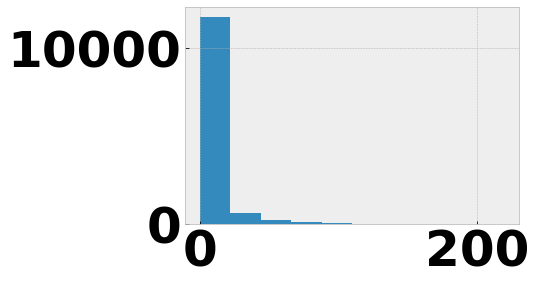

In [116]:
# plt.figure(figsize=(9, 7))
# sns.distplot(df['revenue'], color='g', bins=100, hist_kws={'alpha': 0.4});
df['revenue'].hist()

## Numerical Data Distribution

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


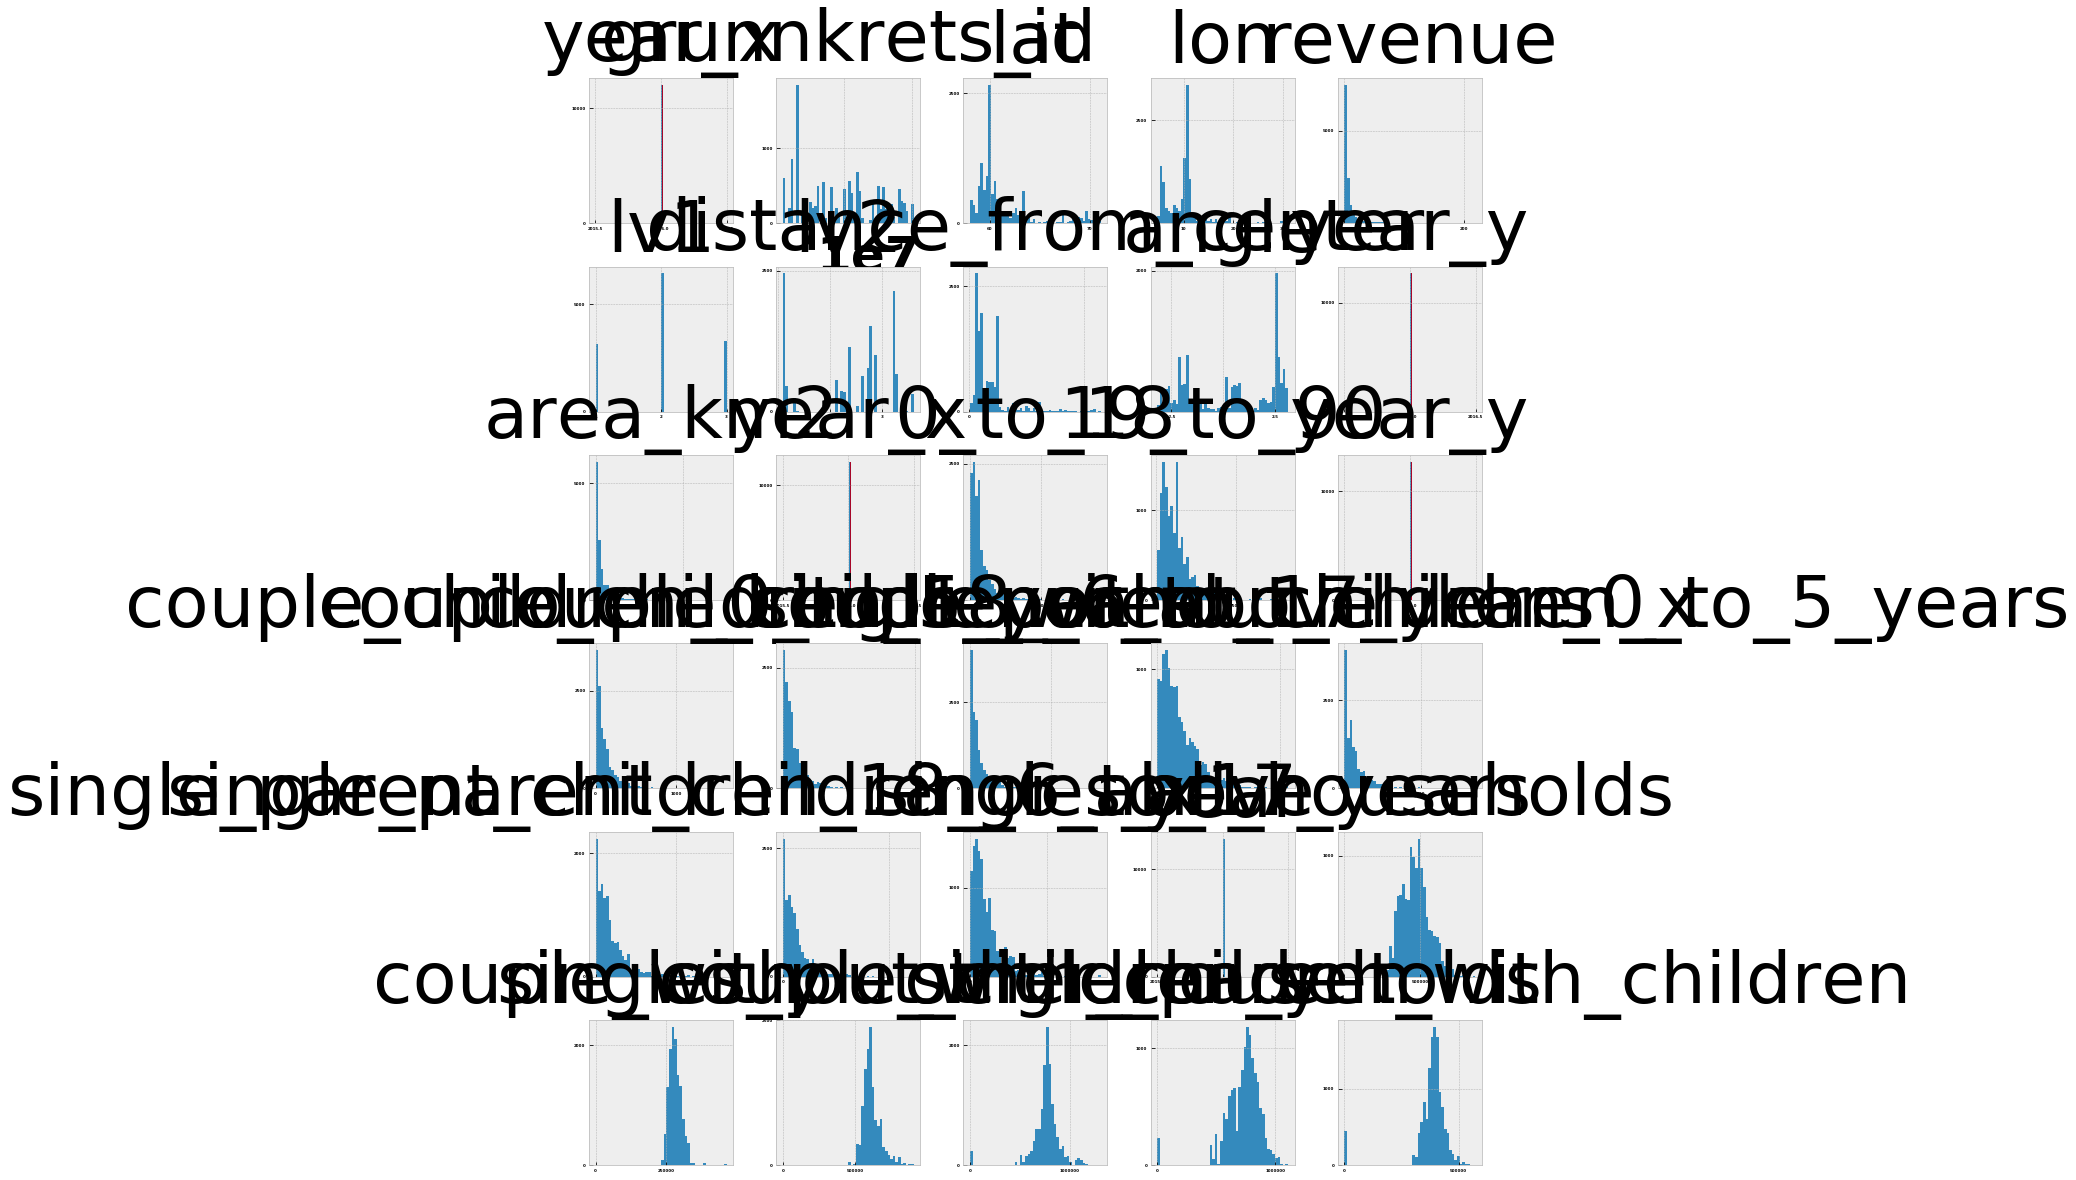

In [53]:
df_numerical_features.hist(figsize=(16, 20), bins=50, xlabelsize=4, ylabelsize=4); 

## Correlation with Revenue

In [54]:
df_num_corr = df_numerical_features.corr()['revenue'][:-1] # -1 because the latest row is SalePrice
df_num_corr
golden_features_list = df_num_corr[abs(df_num_corr) > 0.00].sort_values(ascending=False)
print("The top {} correlated values with revenue are:\n{}".format(len(golden_features_list), golden_features_list))

The top 24 correlated values with revenue are:
revenue                                 1.000000
all_households                          0.037117
singles_y                               0.034573
lv2                                     0.021941
0_to_18                                 0.021079
other_households                        0.020773
couple_children_6_to_17_years           0.016798
couple_with_children                    0.014701
grunnkrets_id                           0.014588
area_km2                                0.013703
couple_children_0_to_5_years            0.012815
couple_without_children_y               0.012283
couple_children_18_or_above             0.011553
single_parent_children_18_or_above      0.011551
distance_from_center                    0.011382
single_parent_children_6_to_17_years    0.008844
lat                                     0.007547
19_to_90                                0.004041
lon                                     0.003112
single_parent_children

# Feature Engineering

## 1. Dropping Redundant Columns

In [117]:
stores_train_merged['dep_ratio'] = stores_train_merged['0_to_18'] / (stores_train_merged['0_to_18'] + stores_train_merged['19_to_90'])
stores_test_merged['dep_ratio'] = stores_test_merged['0_to_18'] / (stores_test_merged['0_to_18'] + stores_test_merged['19_to_90'])


In [118]:
stores_train_finalcols = stores_train_merged.drop(columns=[
    'year_x', 'store_name', 'plaace_hierarchy_id', 'grunnkrets_id', 'address', 'lv1', 'lv2', 'lv3', 'lv4', 'year_y',
    'grunnkrets_name', 'district_name', 'geometry','0_to_18','19_to_90','lon','single_parent_children_18_or_above','couple_children_18_or_above','single_parent_with_children'])

stores_test_finalcols = stores_test_merged.drop(columns=[
    'year_x', 'store_name', 'plaace_hierarchy_id', 'grunnkrets_id', 'address', 'lv1', 'lv2', 'lv3', 'lv4', 'year_y',
    'grunnkrets_name', 'district_name', 'geometry','0_to_18','19_to_90','lon','single_parent_children_18_or_above','couple_children_18_or_above','single_parent_with_children'])


In [119]:
stores_train_finalcols

,store_id,sales_channel_name_x,lat,chain_name,mall_name,revenue,sales_channel_name_y,lv1_desc,lv2_desc,lv3_desc,lv4_desc,distance_from_center,angle,municipality_name,area_km2,couple_children_0_to_5_years,couple_children_6_to_17_years,couple_without_children_x,single_parent_children_0_to_5_years,single_parent_children_6_to_17_years,singles_x,year,all_households,singles_y,couple_without_children_y,couple_with_children,other_households,dep_ratio
0,983540538-974187930-44774,Hamburger restaurants,59.743104,MCDONALDS,Magasinet Drammen,17.998,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,1.483925,2.999938,Drammen,0.155779,20.0,8.0,28.0,4.0,11.0,75.0,2016.0,398700.0,277500.0,669100.0,832800.0,679600.0,0.159236
1,987074191-973117734-44755,Hamburger restaurants,59.913759,MCDONALDS,NaN,23.828,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,1.493786,2.624389,Oslo,0.264278,0.0,0.0,0.0,0.0,0.0,6.0,2016.0,374800.0,295000.0,679600.0,802200.0,604100.0,0.187076
2,984890265-981157303-64491,Hamburger restaurants,60.164751,BURGER KING,Kuben Hønefoss,16.099,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,1.079018,2.898973,Ringerike,0.160152,45.0,38.0,84.0,13.0,12.0,150.0,2016.0,347900.0,251900.0,589900.0,673100.0,637600.0,0.180108
3,914057442-992924179-126912,Hamburger restaurants,67.283669,BURGER KING,Glasshuspassasjen,9.296,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,7.489049,0.625420,Bodø,0.095029,41.0,27.0,126.0,11.0,15.0,254.0,2016.0,394000.0,293600.0,602000.0,675800.0,699600.0,0.097046
4,913018583-913063538-668469,Hamburger restaurants,63.358068,BURGER KING,Tillertorget,4.528,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,2.179184,0.174997,Trondheim,0.251070,0.0,0.0,0.0,0.0,0.0,3.0,2016.0,623700.0,296500.0,635700.0,779700.0,801300.0,0.187076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,915789943-915806929-781991,Beer and soda shop,59.416276,NaN,NaN,0.088,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,1.860369,2.877541,Horten,0.291337,159.0,113.0,488.0,46.0,58.0,556.0,2016.0,381900.0,263600.0,563700.0,682000.0,636800.0,0.127968
12855,917921733-917982368-868081,Beer and soda shop,60.799991,GULATING GRUPPEN,CC Gjøvik,1.816,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,0.810793,2.104077,Gjøvik,0.137188,47.0,14.0,138.0,5.0,19.0,256.0,2016.0,292000.0,243200.0,457800.0,465300.0,477700.0,0.083499
12856,911721961-911764474-496764,Beer and soda shop,59.946562,GULATING GRUPPEN,Strømmen Storsenter,38.225,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,1.620608,2.466972,Skedsmo,0.123431,147.0,76.0,332.0,50.0,33.0,407.0,2016.0,440200.0,286200.0,595100.0,759300.0,745200.0,0.129812
12857,914337046-914343372-721294,Beer and soda shop,58.850261,NaN,Bystasjonen,3.642,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,4.870736,-2.077065,Sandnes,0.034857,22.0,7.0,86.0,6.0,10.0,114.0,2016.0,382400.0,282700.0,597500.0,601500.0,649900.0,0.078292


## 2. One Hot Encoding - Do not need to run this part anymore for LightGBM & CatBoost

### Using LabelEncoder

In [71]:
#categorical data
label_encoder = preprocessing.LabelEncoder()
categorical_cols = ['sales_channel_name_x', 'chain_name', 'municipality_name', 'sales_channel_name_y', 'lv1_desc',
'lv2_desc', 'lv3_desc', 'lv4_desc','mall_name'] 

df_res = stores_train_finalcols.append(stores_test_finalcols)

,store_id,sales_channel_name_x,lat,lon,chain_name,mall_name,revenue,sales_channel_name_y,lv1_desc,lv2_desc,lv3_desc,lv4_desc,municipality_name,area_km2,0_to_18,19_to_90,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children_x,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles_x,year,all_households,singles_y,couple_without_children_y,couple_with_children,other_households,single_parent_with_children
0,983540538-974187930-44774,39,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,Drammen,0.155779,25.000000,132.000000,20.0,0.0,8.0,28.0,4.0,6.0,11.0,75.0,2016.0,398700.0,277500.0,669100.0,832800.0,679600.0,349500.0
1,987074191-973117734-44755,39,59.913759,10.734031,MCDONALDS,NaN,23.828,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,Oslo,0.264278,143.178518,622.172205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2016.0,374800.0,295000.0,679600.0,802200.0,604100.0,397700.0
2,984890265-981157303-64491,39,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,Ringerike,0.160152,67.000000,305.000000,45.0,9.0,38.0,84.0,13.0,6.0,12.0,150.0,2016.0,347900.0,251900.0,589900.0,673100.0,637600.0,327000.0
3,914057442-992924179-126912,39,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,Bodø,0.095029,46.000000,428.000000,41.0,10.0,27.0,126.0,11.0,8.0,15.0,254.0,2016.0,394000.0,293600.0,602000.0,675800.0,699600.0,335200.0
4,913018583-913063538-668469,39,63.358068,10.374832,BURGER KING,Tillertorget,4.528,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,Trondheim,0.251070,143.178518,622.172205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2016.0,623700.0,296500.0,635700.0,779700.0,801300.0,413600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8572,917323003-917383529-844309,5,59.259575,5.325813,GULATING GRUPPEN,NaN,NaN,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,Karmøy,1.708924,92.000000,336.000000,56.0,23.0,115.0,120.0,7.0,16.0,14.0,60.0,2016.0,507700.0,264800.0,607300.0,768400.0,785200.0,377800.0
8573,917353379-917411824-845904,5,58.976219,5.721546,NaN,NaN,NaN,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,Stavanger,0.310575,90.000000,929.000000,102.0,12.0,47.0,352.0,14.0,8.0,18.0,433.0,2016.0,484900.0,327100.0,669400.0,829500.0,721800.0,418900.0
8574,917072302-917089248-833647,5,59.928330,11.163202,GULATING GRUPPEN,NaN,NaN,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,Fet,1.627789,237.000000,1050.000000,200.0,84.0,222.0,316.0,13.0,46.0,65.0,324.0,2016.0,614000.0,295200.0,663400.0,842000.0,866000.0,478900.0
8575,916960557-916993161-829908,5,60.445790,5.161587,NaN,NaN,NaN,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,Askøy,1.103012,231.000000,683.000000,202.0,101.0,207.0,178.0,16.0,40.0,34.0,112.0,2016.0,652800.0,282800.0,627300.0,807400.0,849500.0,383500.0


### Using Get_Dummies

In [141]:
#categorical data
categorical_cols = ['sales_channel_name_x', 'chain_name', 'municipality_name', 'sales_channel_name_y', 'lv1_desc',
'lv2_desc', 'lv3_desc', 'lv4_desc','mall_name'] 

df_res = stores_train_finalcols.append(stores_test_finalcols)

#import pandas as pd
df_res_onehot = pd.get_dummies(df_res, columns = categorical_cols)
stores_train_finalcols_onehot = df_res_onehot.iloc[:12859]
stores_test_finalcols_onehot = df_res_onehot.iloc[12859:]

stores_test_finalcols_onehot

store_id        lat        lon  revenue  area_km2  \
2448  951635200-897514982-167862  59.802559   5.819865      NaN  1.082595   
2449   992480939-992524235-98502  58.941515   5.745594      NaN  0.358485   
2450   916749686-974106361-40966  59.687080   9.629682      NaN  0.293455   
2451  995992574-971996641-130780  60.202481   5.447288      NaN  0.901113   
2452  997985613-998000475-427101  59.696582   8.065247      NaN  2.299577   
...                          ...        ...        ...      ...       ...   
8572  917323003-917383529-844309  59.259575   5.325813      NaN  1.708924   
8573  917353379-917411824-845904  58.976219   5.721546      NaN  0.310575   
8574  917072302-917089248-833647  59.928330  11.163202      NaN  1.627789   
8575  916960557-916993161-829908  60.445790   5.161587      NaN  1.103012   
8576   987280891-972040746-45320  59.097903   9.055490      NaN  1.677433   

      0_to_18  19_to_90  couple_children_0_to_5_years  \
2448    100.0     291.0                          67.0   
2449    266.0    1335.0                         229.0   
2450    156.0     722.0                         125.0   
2451    309.0     921.0                         289.0   
2452    125.0     477.0                         102.0   
...       ...       ...                           ...   
8572     92.0     336.0                          56.0   
8573     90.0     929.0                         102.0   
8574    237.0    1050.0                         200.0   
8575    231.0     683.0                         202.0   
8576    299.0    1003.0                         233.0   

      couple_children_18_or_above  couple_children_6_to_17_years  \
2448                         35.0                          106.0   
2449                        103.0                          229.0   
2450                         31.0                          124.0   
2451                         88.0                          208.0   
2452                         73.0                          127.0   
...                           ...                            ...   
8572                         23.0                          115.0   
8573                         12.0                           47.0   
8574                         84.0                          222.0   
8575                        101.0                          207.0   
8576                         75.0                          249.0   

      couple_without_children_x  single_parent_children_0_to_5_years  \
2448                      100.0                                  5.0   
2449                      382.0                                 15.0   
2450                      166.0                                 14.0   
2451                      276.0                                 27.0   
2452                       94.0                                  0.0   
...                         ...                                  ...   
8572                      120.0                                  7.0   
8573                      352.0                                 14.0   
8574                      316.0                                 13.0   
8575                      178.0                                 16.0   
8576                      274.0                                 29.0   

      single_parent_children_18_or_above  \
2448                                 0.0   
2449                                29.0   
2450                                23.0   
2451                                38.0   
2452                                17.0   
...                                  ...   
8572                                16.0   
8573                                 8.0   
8574                                46.0   
8575                                40.0   
8576                                32.0   

      single_parent_children_6_to_17_years  singles_x    year  all_households  \
2448                                  10.0       64.0  2016.0        585200.0   
2449                                  51.

## 3. Handling Outliers

In [158]:
#Dropping the outlier rows with Percentiles - Run this if you are using One Hot Encoder
# upper_lim = stores_train_finalcols_onehot['revenue'].quantile(.95)
# lower_lim = stores_train_finalcols_onehot['revenue'].quantile(.05)

# stores_train_finalcols_onehot = stores_train_finalcols_onehot[(stores_train_finalcols_onehot['revenue'] < upper_lim) & (stores_train_finalcols_onehot['revenue'] > lower_lim)]
# X_train = stores_train_finalcols_onehot.drop(columns=['revenue', 'store_id'])
# y_train = stores_train_finalcols_onehot.revenue 
# X_test = stores_test_finalcols_onehot.drop(columns=['store_id'])
# X_train


In [120]:
#Dropping the outlier rows with Percentiles - Run this if NOT using One Hot Encoder
upper_lim = stores_train_finalcols['revenue'].quantile(.95)
lower_lim = stores_train_finalcols['revenue'].quantile(.05)

stores_train_finalcols = stores_train_finalcols[(stores_train_finalcols['revenue'] < upper_lim) & (stores_train_finalcols['revenue'] > lower_lim)]
X_train = stores_train_finalcols.drop(columns=['revenue', 'store_id'])
y_train = stores_train_finalcols.revenue 
X_test = stores_test_finalcols.drop(columns=['store_id'])

#Imputing missing values for both train and test
X_train.fillna(-999, inplace=True)
X_test.fillna(-999,inplace=True)

categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_features_indices

array([ 0,  2,  3,  4,  5,  6,  7,  8, 11])

# Models

## Model 1 - catBoost

### Log Revenue Value to Match Loss Function RMSE

In [121]:
y_train_log = np.log(y_train)
y_train_log

0        2.890261
1        3.170861
2        2.778757
3        2.229584
4        1.510280
           ...   
12852    0.064851
12853    1.049772
12855    0.596636
12857    1.292533
12858    0.845010
Name: revenue, Length: 11572, dtype: float64

### Do Internal Split

In [122]:
# Added internal split
from sklearn.model_selection import train_test_split
X_training, X_testing, y_training, y_testing = train_test_split(X_train, y_train_log, train_size=0.8, random_state=123)

In [62]:
import catboost as ctb

In [67]:
best_params = {
            'bagging_temperature': 0.5,
            'depth': 8,
            'iterations': 1000,
            'l2_leaf_reg': 25,
            'learning_rate': 0.05,
            'sampling_frequency': 'PerTreeLevel',
            'leaf_estimation_method': 'Gradient',
            'random_strength': 0.8,
            'boosting_type': 'Ordered',
            'feature_border_type': 'MaxLogSum',
            'l2_leaf_reg': 50,
            'max_ctr_complexity': 2,
            'fold_len_multiplier': 2
    }
model = ctb.CatBoostRegressor(**best_params,
                               loss_function='RMSE',
                               eval_metric='AUC',
                               nan_mode='Min',
                               thread_count=8,
                               task_type='CPU',
                               verbose=False)
model.fit(X_training, y_training, cat_features=categorical_features_indices)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

### Parameter Tuning Using GridSearch

In [123]:
from sklearn.model_selection import GridSearchCV

train_dataset = ctb.Pool(X_training, y_training, cat_features=categorical_features_indices) 
model = ctb.CatBoostRegressor()

#create the grid
grid = {'depth' : [8],
              'learning_rate' : [0.1],
              'iterations'    : [200],
        'l2_leaf_reg': [0.5]}
search_results = model.grid_search(grid, train_dataset, cv=5)
print("\nBest Params : ", search_results['params'])

0:	learn: 1.5309355	test: 1.5204278	best: 1.5204278 (0)	total: 144ms	remaining: 28.6s
1:	learn: 1.4518514	test: 1.4384595	best: 1.4384595 (1)	total: 205ms	remaining: 20.3s
2:	learn: 1.3781168	test: 1.3611680	best: 1.3611680 (2)	total: 318ms	remaining: 20.9s
3:	learn: 1.3135194	test: 1.2931783	best: 1.2931783 (3)	total: 614ms	remaining: 30.1s
4:	learn: 1.2590615	test: 1.2381545	best: 1.2381545 (4)	total: 894ms	remaining: 34.9s
5:	learn: 1.2120092	test: 1.1886994	best: 1.1886994 (5)	total: 935ms	remaining: 30.2s
6:	learn: 1.1736846	test: 1.1483739	best: 1.1483739 (6)	total: 943ms	remaining: 26s
7:	learn: 1.1407463	test: 1.1134444	best: 1.1134444 (7)	total: 996ms	remaining: 23.9s
8:	learn: 1.1139324	test: 1.0846412	best: 1.0846412 (8)	total: 1.01s	remaining: 21.4s
9:	learn: 1.0899266	test: 1.0602283	best: 1.0602283 (9)	total: 1.04s	remaining: 19.7s
10:	learn: 1.0701968	test: 1.0400784	best: 1.0400784 (10)	total: 1.07s	remaining: 18.3s
11:	learn: 1.0541108	test: 1.0236823	best: 1.0236823 (

94:	learn: 0.8602846	test: 0.9178176	best: 0.9175732 (85)	total: 11.3s	remaining: 12.5s
95:	learn: 0.8594035	test: 0.9180186	best: 0.9175732 (85)	total: 11.4s	remaining: 12.3s
96:	learn: 0.8585110	test: 0.9180311	best: 0.9175732 (85)	total: 11.4s	remaining: 12.1s
97:	learn: 0.8576578	test: 0.9180127	best: 0.9175732 (85)	total: 11.4s	remaining: 11.9s
98:	learn: 0.8572388	test: 0.9181835	best: 0.9175732 (85)	total: 11.5s	remaining: 11.7s
99:	learn: 0.8557831	test: 0.9179515	best: 0.9175732 (85)	total: 11.5s	remaining: 11.5s
100:	learn: 0.8546708	test: 0.9178049	best: 0.9175732 (85)	total: 11.5s	remaining: 11.3s
101:	learn: 0.8537399	test: 0.9179295	best: 0.9175732 (85)	total: 11.6s	remaining: 11.2s
102:	learn: 0.8526280	test: 0.9178140	best: 0.9175732 (85)	total: 11.7s	remaining: 11s
103:	learn: 0.8516185	test: 0.9183284	best: 0.9175732 (85)	total: 11.7s	remaining: 10.8s
104:	learn: 0.8499983	test: 0.9185131	best: 0.9175732 (85)	total: 11.8s	remaining: 10.7s
105:	learn: 0.8487082	test: 0

189:	learn: 0.7581870	test: 0.9217498	best: 0.9175732 (85)	total: 17.7s	remaining: 934ms
190:	learn: 0.7575904	test: 0.9218753	best: 0.9175732 (85)	total: 17.8s	remaining: 838ms
191:	learn: 0.7569120	test: 0.9218249	best: 0.9175732 (85)	total: 17.8s	remaining: 743ms
192:	learn: 0.7564651	test: 0.9219787	best: 0.9175732 (85)	total: 17.9s	remaining: 648ms
193:	learn: 0.7555761	test: 0.9222244	best: 0.9175732 (85)	total: 17.9s	remaining: 554ms
194:	learn: 0.7545855	test: 0.9222185	best: 0.9175732 (85)	total: 18s	remaining: 461ms
195:	learn: 0.7534199	test: 0.9222296	best: 0.9175732 (85)	total: 18s	remaining: 368ms
196:	learn: 0.7525014	test: 0.9221866	best: 0.9175732 (85)	total: 18s	remaining: 275ms
197:	learn: 0.7516242	test: 0.9223988	best: 0.9175732 (85)	total: 18.1s	remaining: 183ms
198:	learn: 0.7508644	test: 0.9225662	best: 0.9175732 (85)	total: 18.1s	remaining: 91ms
199:	learn: 0.7502941	test: 0.9224797	best: 0.9175732 (85)	total: 18.2s	remaining: 0us

bestTest = 0.917573208
bestIt

82:	learn: 0.8611775	test: 0.9532685	best: 0.9527316 (45)	total: 4.64s	remaining: 6.54s
83:	learn: 0.8591468	test: 0.9530952	best: 0.9527316 (45)	total: 4.69s	remaining: 6.48s
84:	learn: 0.8577892	test: 0.9529743	best: 0.9527316 (45)	total: 4.75s	remaining: 6.42s
85:	learn: 0.8562977	test: 0.9539383	best: 0.9527316 (45)	total: 4.82s	remaining: 6.39s
86:	learn: 0.8557833	test: 0.9537122	best: 0.9527316 (45)	total: 4.86s	remaining: 6.32s
87:	learn: 0.8545732	test: 0.9538014	best: 0.9527316 (45)	total: 4.9s	remaining: 6.23s
88:	learn: 0.8539683	test: 0.9537502	best: 0.9527316 (45)	total: 4.93s	remaining: 6.14s
89:	learn: 0.8531377	test: 0.9537836	best: 0.9527316 (45)	total: 4.95s	remaining: 6.05s
90:	learn: 0.8512445	test: 0.9534686	best: 0.9527316 (45)	total: 5.02s	remaining: 6.01s
91:	learn: 0.8495370	test: 0.9534466	best: 0.9527316 (45)	total: 5.06s	remaining: 5.95s
92:	learn: 0.8484365	test: 0.9536197	best: 0.9527316 (45)	total: 5.14s	remaining: 5.91s
93:	learn: 0.8467716	test: 0.9538

177:	learn: 0.7545902	test: 0.9643046	best: 0.9527316 (45)	total: 9.46s	remaining: 1.17s
178:	learn: 0.7534773	test: 0.9647703	best: 0.9527316 (45)	total: 9.5s	remaining: 1.11s
179:	learn: 0.7527908	test: 0.9646623	best: 0.9527316 (45)	total: 9.54s	remaining: 1.06s
180:	learn: 0.7523254	test: 0.9646956	best: 0.9527316 (45)	total: 9.58s	remaining: 1s
181:	learn: 0.7517322	test: 0.9646318	best: 0.9527316 (45)	total: 9.65s	remaining: 954ms
182:	learn: 0.7512979	test: 0.9646433	best: 0.9527316 (45)	total: 9.71s	remaining: 902ms
183:	learn: 0.7502981	test: 0.9647742	best: 0.9527316 (45)	total: 9.78s	remaining: 851ms
184:	learn: 0.7490071	test: 0.9645297	best: 0.9527316 (45)	total: 9.83s	remaining: 797ms
185:	learn: 0.7478646	test: 0.9643978	best: 0.9527316 (45)	total: 9.88s	remaining: 744ms
186:	learn: 0.7469416	test: 0.9642254	best: 0.9527316 (45)	total: 9.97s	remaining: 693ms
187:	learn: 0.7460601	test: 0.9642012	best: 0.9527316 (45)	total: 10s	remaining: 640ms
188:	learn: 0.7449836	test:

71:	learn: 0.8725682	test: 0.9597924	best: 0.9591422 (61)	total: 5.23s	remaining: 9.3s
72:	learn: 0.8714282	test: 0.9592466	best: 0.9591422 (61)	total: 5.41s	remaining: 9.42s
73:	learn: 0.8687849	test: 0.9594498	best: 0.9591422 (61)	total: 5.48s	remaining: 9.32s
74:	learn: 0.8676223	test: 0.9596261	best: 0.9591422 (61)	total: 5.53s	remaining: 9.22s
75:	learn: 0.8675762	test: 0.9595906	best: 0.9591422 (61)	total: 5.53s	remaining: 9.03s
76:	learn: 0.8663211	test: 0.9596547	best: 0.9591422 (61)	total: 5.61s	remaining: 8.96s
77:	learn: 0.8650398	test: 0.9595789	best: 0.9591422 (61)	total: 5.64s	remaining: 8.82s
78:	learn: 0.8637326	test: 0.9595643	best: 0.9591422 (61)	total: 5.71s	remaining: 8.74s
79:	learn: 0.8625180	test: 0.9595702	best: 0.9591422 (61)	total: 5.74s	remaining: 8.61s
80:	learn: 0.8610033	test: 0.9589803	best: 0.9589803 (80)	total: 5.77s	remaining: 8.48s
81:	learn: 0.8595351	test: 0.9588042	best: 0.9588042 (81)	total: 5.87s	remaining: 8.45s
82:	learn: 0.8583030	test: 0.9591

165:	learn: 0.7635266	test: 0.9583904	best: 0.9565281 (112)	total: 13.3s	remaining: 2.73s
166:	learn: 0.7628695	test: 0.9581198	best: 0.9565281 (112)	total: 13.4s	remaining: 2.65s
167:	learn: 0.7618637	test: 0.9580912	best: 0.9565281 (112)	total: 13.5s	remaining: 2.56s
168:	learn: 0.7609835	test: 0.9579017	best: 0.9565281 (112)	total: 13.5s	remaining: 2.47s
169:	learn: 0.7601635	test: 0.9579623	best: 0.9565281 (112)	total: 13.5s	remaining: 2.38s
170:	learn: 0.7590761	test: 0.9577523	best: 0.9565281 (112)	total: 13.6s	remaining: 2.3s
171:	learn: 0.7583498	test: 0.9576487	best: 0.9565281 (112)	total: 13.6s	remaining: 2.21s
172:	learn: 0.7573023	test: 0.9577509	best: 0.9565281 (112)	total: 13.7s	remaining: 2.14s
173:	learn: 0.7561606	test: 0.9579526	best: 0.9565281 (112)	total: 13.7s	remaining: 2.05s
174:	learn: 0.7554889	test: 0.9580249	best: 0.9565281 (112)	total: 13.8s	remaining: 1.97s
175:	learn: 0.7546449	test: 0.9577719	best: 0.9565281 (112)	total: 13.8s	remaining: 1.88s
176:	learn:

60:	learn: 0.8933345	test: 0.9444877	best: 0.9444877 (60)	total: 3.03s	remaining: 6.91s
61:	learn: 0.8921334	test: 0.9443476	best: 0.9443476 (61)	total: 3.06s	remaining: 6.82s
62:	learn: 0.8911405	test: 0.9441141	best: 0.9441141 (62)	total: 3.12s	remaining: 6.78s
63:	learn: 0.8909393	test: 0.9441170	best: 0.9441141 (62)	total: 3.13s	remaining: 6.65s
64:	learn: 0.8898142	test: 0.9444705	best: 0.9441141 (62)	total: 3.17s	remaining: 6.58s
65:	learn: 0.8893998	test: 0.9444093	best: 0.9441141 (62)	total: 3.2s	remaining: 6.49s
66:	learn: 0.8872469	test: 0.9441884	best: 0.9441141 (62)	total: 3.25s	remaining: 6.46s
67:	learn: 0.8861275	test: 0.9438779	best: 0.9438779 (67)	total: 3.28s	remaining: 6.37s
68:	learn: 0.8854713	test: 0.9435905	best: 0.9435905 (68)	total: 3.32s	remaining: 6.3s
69:	learn: 0.8842543	test: 0.9438647	best: 0.9435905 (68)	total: 3.35s	remaining: 6.21s
70:	learn: 0.8836988	test: 0.9437434	best: 0.9435905 (68)	total: 3.39s	remaining: 6.15s
71:	learn: 0.8818905	test: 0.94324

153:	learn: 0.7847737	test: 0.9438582	best: 0.9411251 (105)	total: 7.71s	remaining: 2.3s
154:	learn: 0.7836090	test: 0.9437378	best: 0.9411251 (105)	total: 7.79s	remaining: 2.26s
155:	learn: 0.7820202	test: 0.9435640	best: 0.9411251 (105)	total: 7.95s	remaining: 2.24s
156:	learn: 0.7804448	test: 0.9440519	best: 0.9411251 (105)	total: 8.04s	remaining: 2.2s
157:	learn: 0.7796513	test: 0.9441479	best: 0.9411251 (105)	total: 8.2s	remaining: 2.18s
158:	learn: 0.7786300	test: 0.9446591	best: 0.9411251 (105)	total: 8.24s	remaining: 2.13s
159:	learn: 0.7768633	test: 0.9444028	best: 0.9411251 (105)	total: 8.33s	remaining: 2.08s
160:	learn: 0.7753102	test: 0.9446440	best: 0.9411251 (105)	total: 8.91s	remaining: 2.16s
161:	learn: 0.7740789	test: 0.9445970	best: 0.9411251 (105)	total: 9.72s	remaining: 2.28s
162:	learn: 0.7733316	test: 0.9445212	best: 0.9411251 (105)	total: 9.8s	remaining: 2.22s
163:	learn: 0.7722601	test: 0.9445821	best: 0.9411251 (105)	total: 9.88s	remaining: 2.17s
164:	learn: 0.

46:	learn: 0.9067684	test: 0.9561861	best: 0.9561861 (46)	total: 3.86s	remaining: 12.6s
47:	learn: 0.9058438	test: 0.9559072	best: 0.9559072 (47)	total: 3.91s	remaining: 12.4s
48:	learn: 0.9037693	test: 0.9558346	best: 0.9558346 (48)	total: 4.03s	remaining: 12.4s
49:	learn: 0.9025917	test: 0.9557918	best: 0.9557918 (49)	total: 4.14s	remaining: 12.4s
50:	learn: 0.9014721	test: 0.9557938	best: 0.9557918 (49)	total: 4.18s	remaining: 12.2s
51:	learn: 0.8994513	test: 0.9559120	best: 0.9557918 (49)	total: 4.25s	remaining: 12.1s
52:	learn: 0.8985014	test: 0.9557335	best: 0.9557335 (52)	total: 4.36s	remaining: 12.1s
53:	learn: 0.8973193	test: 0.9555578	best: 0.9555578 (53)	total: 4.4s	remaining: 11.9s
54:	learn: 0.8966415	test: 0.9553685	best: 0.9553685 (54)	total: 4.43s	remaining: 11.7s
55:	learn: 0.8950284	test: 0.9555643	best: 0.9553685 (54)	total: 4.47s	remaining: 11.5s
56:	learn: 0.8945344	test: 0.9554028	best: 0.9553685 (54)	total: 4.5s	remaining: 11.3s
57:	learn: 0.8930528	test: 0.95514

139:	learn: 0.7979931	test: 0.9569569	best: 0.9531777 (72)	total: 10.8s	remaining: 4.64s
140:	learn: 0.7966067	test: 0.9570713	best: 0.9531777 (72)	total: 10.9s	remaining: 4.55s
141:	learn: 0.7952276	test: 0.9571497	best: 0.9531777 (72)	total: 10.9s	remaining: 4.45s
142:	learn: 0.7945429	test: 0.9569383	best: 0.9531777 (72)	total: 10.9s	remaining: 4.36s
143:	learn: 0.7930398	test: 0.9570922	best: 0.9531777 (72)	total: 11s	remaining: 4.29s
144:	learn: 0.7922608	test: 0.9570477	best: 0.9531777 (72)	total: 11.1s	remaining: 4.21s
145:	learn: 0.7908806	test: 0.9566764	best: 0.9531777 (72)	total: 11.1s	remaining: 4.12s
146:	learn: 0.7894856	test: 0.9569154	best: 0.9531777 (72)	total: 11.2s	remaining: 4.04s
147:	learn: 0.7886426	test: 0.9572618	best: 0.9531777 (72)	total: 11.3s	remaining: 3.95s
148:	learn: 0.7873927	test: 0.9572003	best: 0.9531777 (72)	total: 11.3s	remaining: 3.86s
149:	learn: 0.7868817	test: 0.9574127	best: 0.9531777 (72)	total: 11.3s	remaining: 3.78s
150:	learn: 0.7863665	t

36:	learn: 0.9304357	test: 0.9288172	best: 0.9288172 (36)	total: 2.61s	remaining: 11.5s
37:	learn: 0.9287046	test: 0.9278475	best: 0.9278475 (37)	total: 2.65s	remaining: 11.3s
38:	learn: 0.9262901	test: 0.9276440	best: 0.9276440 (38)	total: 2.69s	remaining: 11.1s
39:	learn: 0.9239043	test: 0.9272653	best: 0.9272653 (39)	total: 2.74s	remaining: 11s
40:	learn: 0.9232639	test: 0.9271473	best: 0.9271473 (40)	total: 2.77s	remaining: 10.7s
41:	learn: 0.9208853	test: 0.9268569	best: 0.9268569 (41)	total: 2.84s	remaining: 10.7s
42:	learn: 0.9193776	test: 0.9261869	best: 0.9261869 (42)	total: 2.9s	remaining: 10.6s
43:	learn: 0.9181657	test: 0.9258322	best: 0.9258322 (43)	total: 2.96s	remaining: 10.5s
44:	learn: 0.9168872	test: 0.9255765	best: 0.9255765 (44)	total: 2.99s	remaining: 10.3s
45:	learn: 0.9149653	test: 0.9248423	best: 0.9248423 (45)	total: 3.03s	remaining: 10.1s
46:	learn: 0.9133505	test: 0.9246249	best: 0.9246249 (46)	total: 3.09s	remaining: 10.1s
47:	learn: 0.9119257	test: 0.924448

133:	learn: 0.8134774	test: 0.9177553	best: 0.9177553 (133)	total: 10.8s	remaining: 5.33s
134:	learn: 0.8125464	test: 0.9176833	best: 0.9176833 (134)	total: 11.1s	remaining: 5.35s
135:	learn: 0.8109212	test: 0.9177651	best: 0.9176833 (134)	total: 11.2s	remaining: 5.27s
136:	learn: 0.8099345	test: 0.9177686	best: 0.9176833 (134)	total: 11.3s	remaining: 5.18s
137:	learn: 0.8077900	test: 0.9176935	best: 0.9176833 (134)	total: 11.3s	remaining: 5.09s
138:	learn: 0.8072523	test: 0.9173446	best: 0.9173446 (138)	total: 11.4s	remaining: 5.02s
139:	learn: 0.8066039	test: 0.9173512	best: 0.9173446 (138)	total: 11.6s	remaining: 4.98s
140:	learn: 0.8060543	test: 0.9175415	best: 0.9173446 (138)	total: 11.7s	remaining: 4.88s
141:	learn: 0.8057626	test: 0.9175387	best: 0.9173446 (138)	total: 11.7s	remaining: 4.79s
142:	learn: 0.8052007	test: 0.9176526	best: 0.9173446 (138)	total: 11.8s	remaining: 4.69s
143:	learn: 0.8049839	test: 0.9175453	best: 0.9173446 (138)	total: 11.8s	remaining: 4.59s
144:	learn

### Using the parameters from GridSearch

In [112]:
best_params = {'depth': 8, 'iterations': 200, 'learning_rate': 0.1, 'l2_leaf_reg': 0.5}
model = ctb.CatBoostRegressor(**best_params,
                               loss_function='RMSE',
                               nan_mode='Min',
                               thread_count=8,
                               task_type='CPU',
                               verbose=False)
model.fit(X_training, y_training, eval_set=(X_testing, y_testing), cat_features=categorical_features_indices, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [124]:
y_train_pred = model.predict(X_training)
y_train_pred[y_train_pred<0] = 0
y_train_pred

#Added
y_test_pred = model.predict(X_testing)
y_test_pred[y_test_pred<0] = 0
y_test_pred

array([1.99977119, 3.12238783, 0.63835107, ..., 0.74387725, 0.40951442,
       1.12573935])

### Reverse log the predictions

In [125]:
y_training = np.exp(y_training)
y_testing = np.exp(y_testing)
y_train_pred = np.exp(y_train_pred)
y_test_pred = np.exp(y_test_pred)

In [126]:
print(f'Train set RMSLE: {rmsle(y_training, y_train_pred) :.4f}')
print(f'Test set RMSLE: {rmsle(y_testing, y_test_pred) :.4f}')

Train set RMSLE: 0.5646
Test set RMSLE: 0.6428


### Predict for X_test

In [127]:
y_test_pred = model.predict(X_test) 
y_test_pred

array([1.0700989 , 1.78802319, 0.69252323, ..., 1.79969487, 1.04930609,
       0.84775524])

In [128]:
y_test_pred_original_values = np.exp(y_test_pred)

### Save Predictions

In [129]:
submission = pd.DataFrame()
submission['id'] = stores_test_finalcols.store_id 
submission['predicted'] = np.asarray(y_test_pred_original_values)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission_46.csv', index=False)
submission

,id,predicted
0,914206820-914239427-717245,2.915668
1,916789157-916823770-824309,5.977624
2,913341082-977479363-2948,1.998752
3,889682582-889697172-28720,4.537537
4,997991699-998006945-417222,8.679515
...,...,...
8572,917323003-917383529-844309,5.867804
8573,917353379-917411824-845904,2.935698
8574,917072302-917089248-833647,6.047802
8575,916960557-916993161-829908,2.855669


### Feature Importance

In [130]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(200, 200))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


Text(0.5, 1.0, 'Feature Importance')

## Model 2 - XGBoost

In [206]:
import xgboost as xg

In [ ]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
  
# Fitting the model
xgb_r.fit(X_train, y_train)
  
# Predict the model
pred = xgb_r.predict(X_test)

In [ ]:
submission = pd.DataFrame()
submission['id'] = stores_test_finalcols_onehot.store_id 
submission['predicted'] = np.asarray(pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission_6.csv', index=False)
submission

## Model 3 - LightGBM

In [28]:
import lightgbm as lgb

ModuleNotFoundError: No module named 'lightgbm'

In [29]:
# Added internal split
from sklearn.model_selection import train_test_split
X_training, X_testing, y_training, y_testing = train_test_split(X_train, y_train, train_size=0.9, random_state=123)

In [217]:
# X_training, X_testing, y_training, y_testing
# X_test
y_testing

8651      4.762
9097      4.030
5018      0.653
4371      0.587
4872     17.377
          ...  
5036      6.967
5702      4.752
7035     15.657
5763      9.397
12652     0.588
Name: revenue, Length: 1042, dtype: float64

### Transform categorical features into the appropriate type that is expected by LightGBM.

In [218]:
for c in X_training.columns:
    col_type = X_training[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_training[c] = X_training[c].astype('category')

for c in X_testing.columns:
    col_type = X_testing[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_testing[c] = X_testing[c].astype('category')

for c in X_test.columns:
    col_type = X_test[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_test[c] = X_test[c].astype('category')

/tmp/ipykernel_940718/2152689381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_training[c] = X_training[c].astype('category')
/tmp/ipykernel_940718/2152689381.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_testing[c] = X_testing[c].astype('category')


In [219]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [220]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_training, y_training)
lgb_eval = lgb.Dataset(X_testing, y_testing, reference=lgb_train)

In [221]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l1: 2.76745	valid_0's l2: 13.5393


/lhome/tbfiora/.local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/lhome/tbfiora/.local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [224]:
y_train_pred = gbm.predict(X_training, num_iteration=gbm.best_iteration)
y_test_pred = gbm.predict(X_testing, num_iteration=gbm.best_iteration)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [225]:
y_pred

array([5.06129161, 7.86470303, 6.09196628, ..., 6.11361056, 4.30811014,
       3.95665463])

In [226]:
print(f'Train set RMSLE: {rmsle(y_training, y_train_pred) :.4f}')
print(f'Test set RMSLE: {rmsle(y_testing, y_test_pred) :.4f}')

Train set RMSLE: 0.6220
Test set RMSLE: 0.6525


In [227]:
submission = pd.DataFrame()
submission['id'] = stores_test_finalcols.store_id 
submission['predicted'] = np.asarray(y_pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission_21.csv', index=False)
submission

,id,predicted
0,914206820-914239427-717245,5.061292
1,916789157-916823770-824309,7.864703
2,913341082-977479363-2948,6.091966
3,889682582-889697172-28720,7.812610
4,997991699-998006945-417222,6.852076
...,...,...
8572,917323003-917383529-844309,6.291849
8573,917353379-917411824-845904,5.248304
8574,917072302-917089248-833647,6.113611
8575,916960557-916993161-829908,4.308110
